# Проект по мэтчингу товаров маркетплейса

# Введение

Задача мэтчинга (сопоставления) является распространённой в сфере машинного обучения и находит применение в различных бизнес-приложениях. Мэтчинг заключается в поиске совпадений между двумя множествами объектов, которые мы называем "документами" и "запросами". На практике эти понятия могут охватывать широкий спектр данных: от текстовых запросов до товарных позиций в интернет-магазинах.

**Цель проекта**

Целью данного проекта является разработка алгоритма для эффективного сопоставления товаров на маркетплейсе. Это включает в себя поиск и выдачу списка товаров, которые наиболее релевантны заданному пользовательскому запросу или нуждам.

**Методы решения задачи**

В рамках проекта используются методы машинного обучения для преобразования товаров и запросов в векторы в многомерном пространстве (эмбеддинги), что позволяет вычислять между ними расстояния и определять степень их сходства. Основным методом поиска ближайших соседей является использование библиотеки FAISS, разработанной Facebook, которая оптимизирована для быстрых поисков в больших объёмах данных.

**Проблемы и вызовы**

Основной вызов проекта — обеспечение высокой скорости и точности мэтчинга при сохранении приемлемого уровня вычислительных ресурсов. Это особенно критично в условиях больших объёмов данных, где классические методы поиска могут быть неэффективны.

**Структура проекта**

1. **Подготовка данных**: Импорт и первичная обработка данных.
2. **Исследовательский анализ данных (EDA)**: Анализ распределений, корреляций и других характеристик данных.
3. **Реализация модели мэтчинга**: Настройка и обучение модели с использованием FAISS.
4. **Оценка результатов**: Расчёт метрики accuracy@5 и анализ результатов.
5. **Оптимизация и тонкая настройка**: Эксперименты с параметрами модели для улучшения результатов.

**Ожидаемые результаты**

Проект направлен на достижение accuracy@5 не менее 0.7, что обеспечит высокую релевантность результатов поиска для пользователей маркетплейса.

## Импорт необходимых библиотек и загрузка данных.


In [4]:
from sklearn.preprocessing import StandardScaler
import faiss
from sklearn.model_selection import train_test_split

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import faiss

import zipfile
from itertools import product
from time import perf_counter

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, RobustScaler
pd.options.mode.chained_assignment = None
import time 
# Настройки отображения для Pandas
pd.set_option('display.max_columns', None)  # Показывать все колонки
pd.set_option('display.max_rows', None)  # Показывать все строки
pd.set_option('display.width', None)  # Автоопределение ширины колонки
pd.set_option('display.max_colwidth', None)  # Показывать полный текст в колонке

In [6]:
train = pd.read_csv('/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/Product matching /train.csv', index_col=0)
base = pd.read_csv('/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/Product matching /base.csv', index_col=0)
validation = pd.read_csv('/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/Product matching /validation.csv', index_col=0)
answer = pd.read_csv('/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/Product matching /validation_answer.csv', index_col=0)

In [7]:
# Показ первых строк каждого DataFrame для предварительного осмотра
display(base.head())
display(train.head())
display(validation.head())
display(answer.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,-30.800995,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,-53.147078,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [8]:
display(base.info())
display(train.info())
display(validation.info())
display(answer.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


None

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

None

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

None

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None

In [9]:
'''
base.duplicated().sum()
'''

'\nbase.duplicated().sum()\n'

In [10]:
'''
%%time 

base = base.drop_duplicates()
'''

'\n%%time \n\nbase = base.drop_duplicates()\n'

In [11]:
'''
base.duplicated().sum()
'''

'\nbase.duplicated().sum()\n'

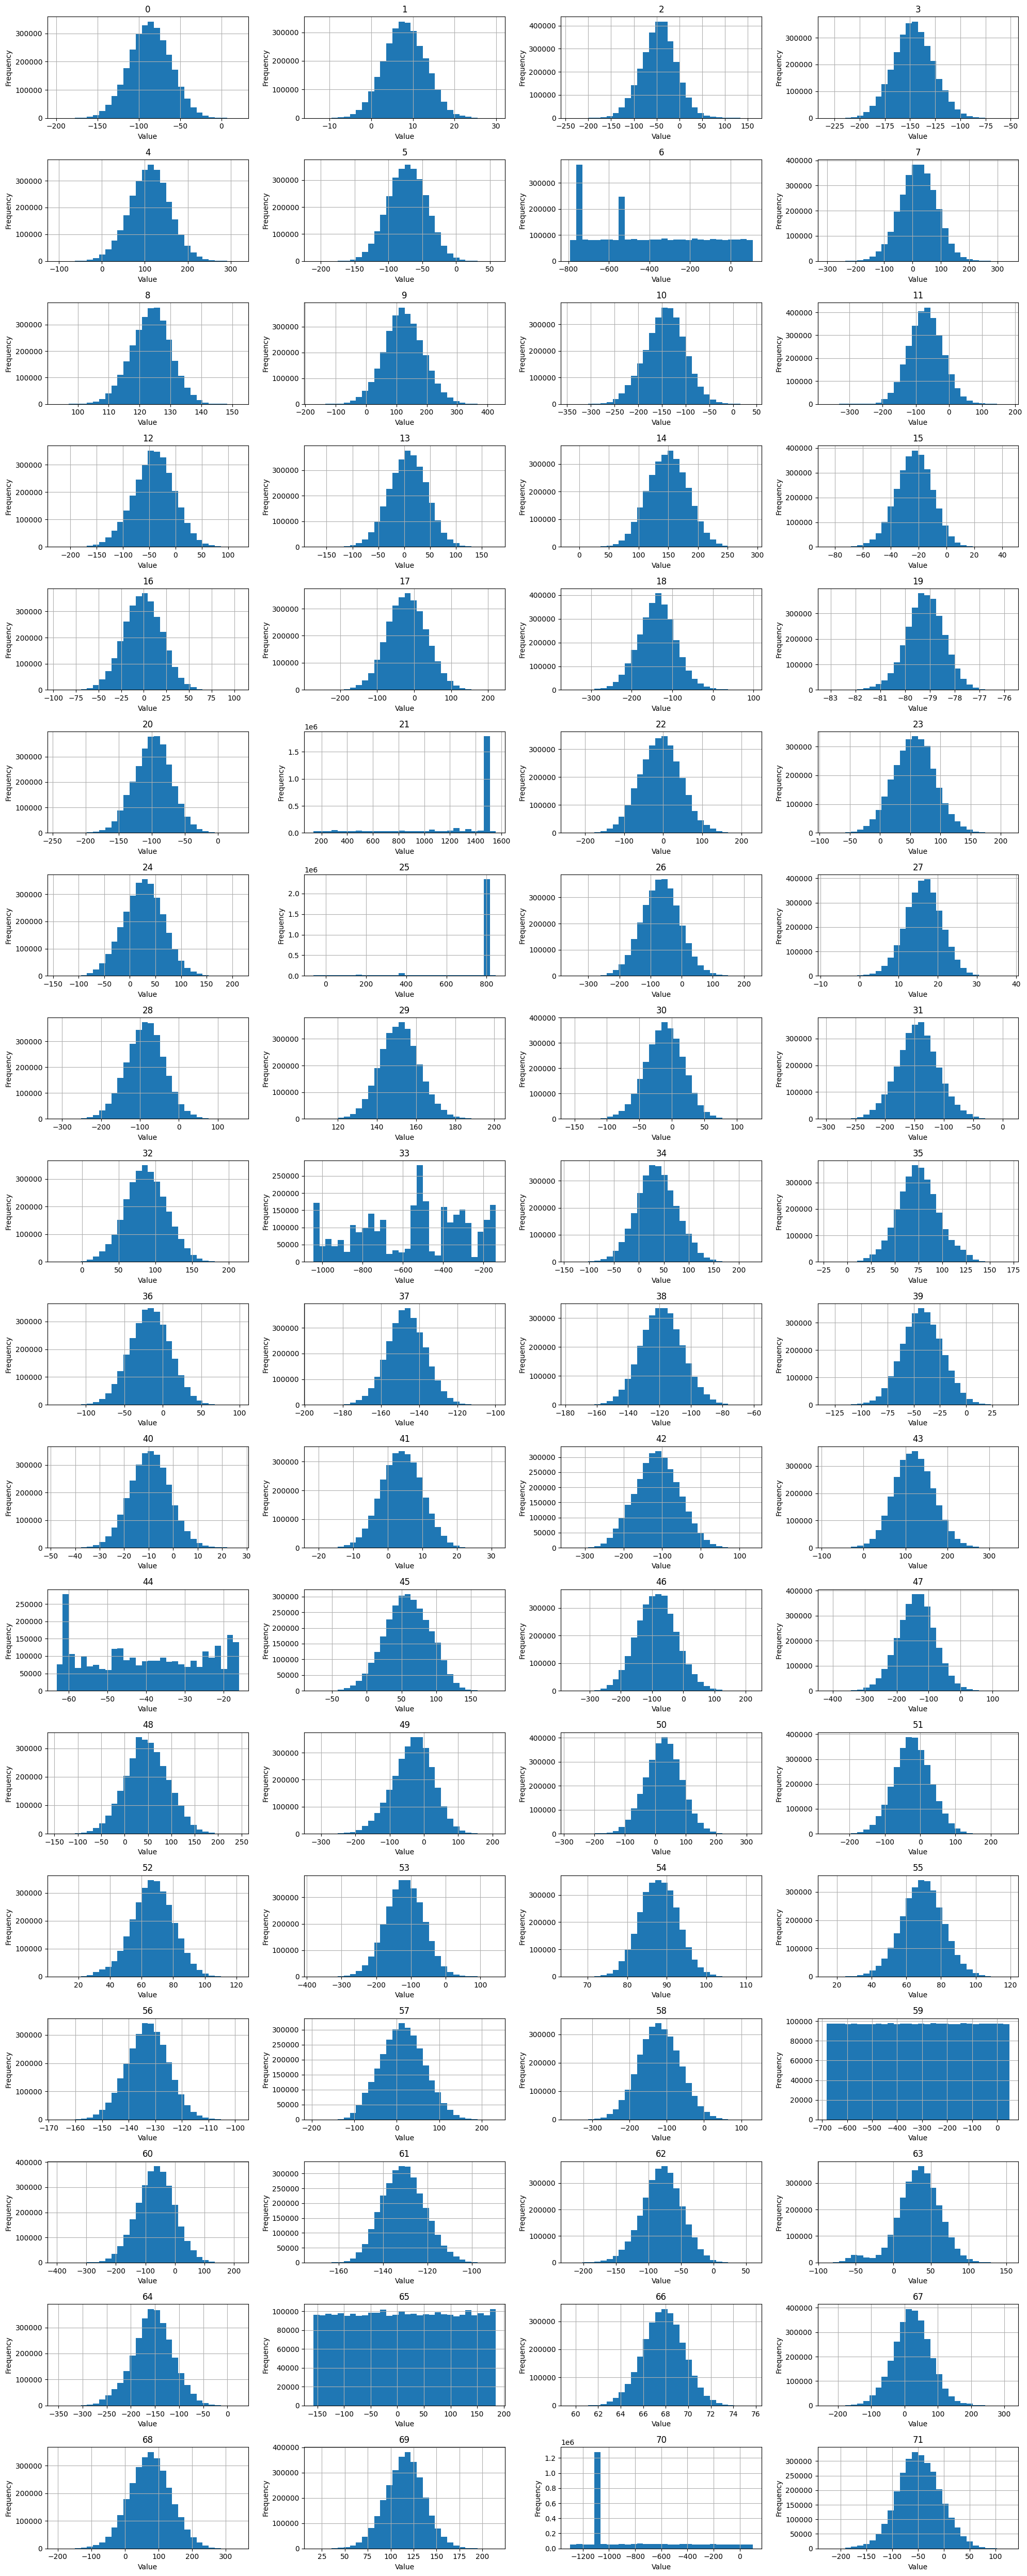

In [12]:
# Определяем колонки для построения гистограмм
columns = base.columns

# Построение гистограмм для каждого признака
fig, axes = plt.subplots(nrows=18, ncols=4, figsize=(20, 50))
axes = axes.flatten()

for i, col in enumerate(columns):
    ax = axes[i]
    base[col].hist(ax=ax, bins=30)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()

**Удаление колонок с выбросами**

В процессе анализа данных было выявлено, что некоторые колонки содержат значительные выбросы и их распределения сильно отличаются от нормального. Это может негативно сказаться на производительности модели, так как выбросы могут исказить общую картину и повлиять на обучение.

**Выбранные для удаления колонки:**
- **Колонка 21**
- **Колонка 25**
- **Колонка 33**
- **Колонка 44**
- **Колонка 59**
- **Колонка 65**

Удаление этих колонок поможет улучшить качество моделирования, так как исключение данных с выбросами и нестандартным распределением позволяет уменьшить вариабельность и потенциальные искажения в результатах.

In [14]:
# Удаление колонок с выбросами
columns_to_drop = ['21', '25', '33', '44', '59', '65']
base = base.drop(columns_to_drop, axis=1)
train = train.drop(columns_to_drop, axis=1)

In [15]:
# Обучение QuantileTransformer на тренировочных данных
quantile_transformer = QuantileTransformer(output_distribution='normal')
quantile_transformer.fit(base[['6', '70']])

# Применение трансформации ко всем наборам данных
datasets = [train, base, validation]
for dataset in datasets:
    dataset[['6', '70']] = quantile_transformer.transform(dataset[['6', '70']])

**Преобразование признаков с использованием Quantile Transformer**

Для улучшения характеристик модели и уменьшения влияния нестандартного распределения данных, мы применяем `QuantileTransformer` к выбранным признакам. Этот метод преобразует фичи таким образом, чтобы их распределение приближалось к нормальному. Это особенно полезно, если данные имеют выбросы или асимметричное распределение, которое может негативно повлиять на процесс обучения моделей.


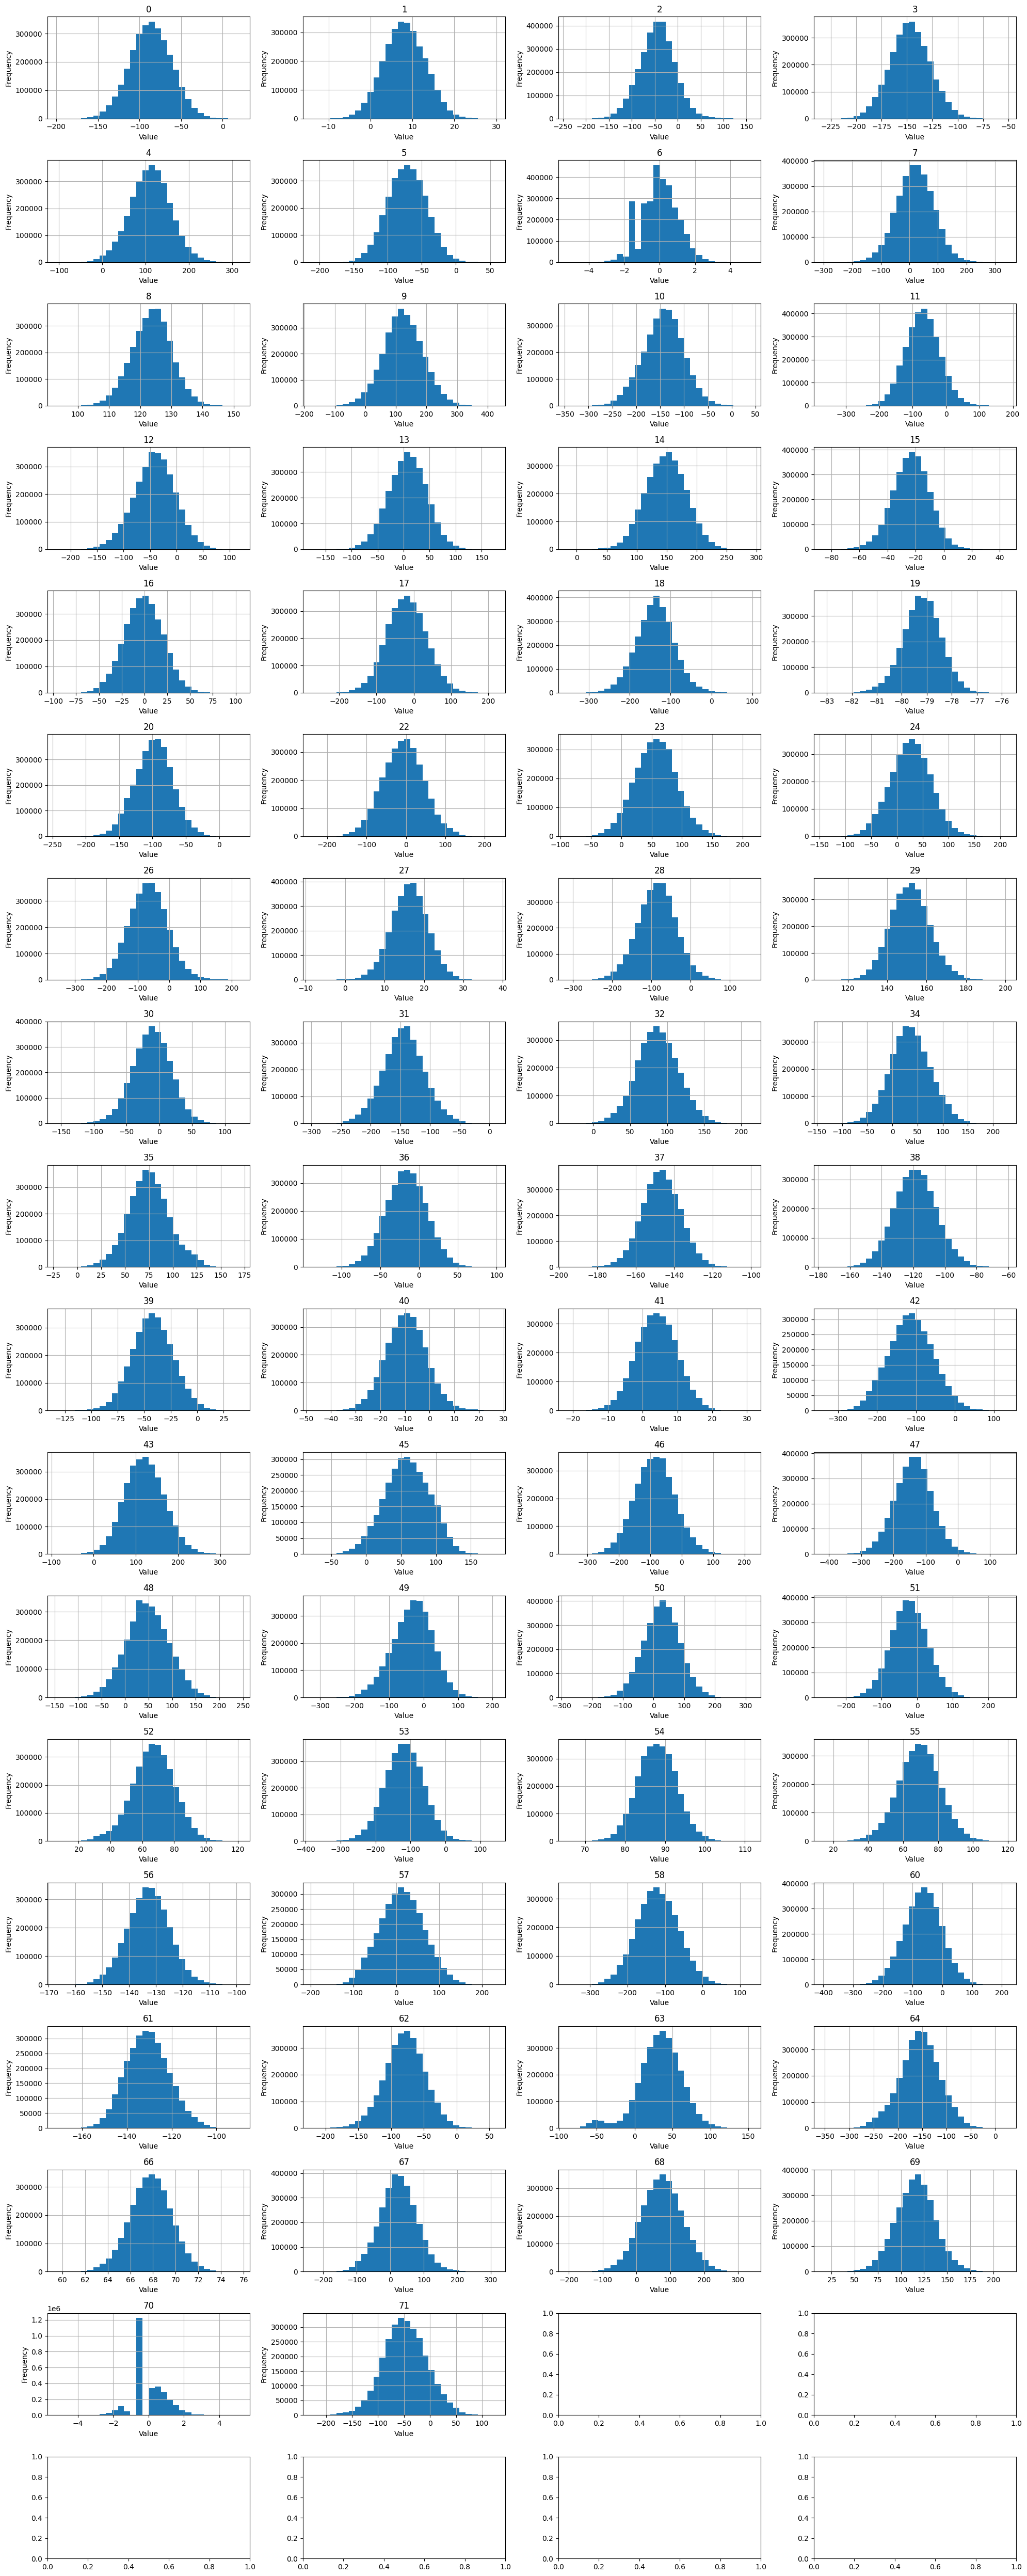

In [17]:
# Определяем колонки для построения гистограмм
columns = base.columns

# Построение гистограмм для каждого признака
fig, axes = plt.subplots(nrows=18, ncols=4, figsize=(20, 50))
axes = axes.flatten()

for i, col in enumerate(columns):
    ax = axes[i]
    base[col].hist(ax=ax, bins=30)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()

In [18]:
# Создание и обучение StandardScaler на тренировочных данных
scaler = StandardScaler()
train_features = train.drop(columns=['Target'])
base_scaled = scaler.fit_transform(base.values)
train_scaled = scaler.transform(train_features.values)

**Использование FAISS для мэтчинга товаров**

В нашем проекте мы используем FAISS (Facebook AI Similarity Search), разработанную Facebook для эффективного поиска по схожести в больших объемах данных. FAISS оптимизирован для высокоскоростного поиска ближайших соседей и поддерживает различные типы индексов, каждый из которых подходит для специфических требований по производительности и точности.

**Основные типы индексов FAISS, используемые в проекте:**

1. **IndexFlatL2**:
   - Это самый базовый индекс в FAISS, использующий L2 (евклидово) расстояние для нахождения ближайших соседей. Он предоставляет точный, но вычислительно затратный метод поиска, подходящий для небольших наборов данных.

2. **IndexIVFFlat**:
   - Индекс с Inverted File System (IVF), который ускоряет поиск, предварительно кластеризуя данные во время тренировки. Этот индекс требует задания количества кластеров и подходит для больших наборов данных, где необходим компромисс между скоростью и точностью.

3. **IndexHNSWFlat**:
   - Использует алгоритм иерархического навигационного малого мира (Hierarchical Navigable Small World), который обеспечивает быстрый поиск при высокой точности на больших датасетах. Этот метод хорошо справляется с проблемой "проклятия размерности".

4. **IndexPQ** (Product Quantization):
   - Предназначен для компрессии данных с помощью квантизации. Это позволяет значительно уменьшить использование памяти при сохранении приемлемой точности поиска. Этот индекс идеален для очень больших датасетов, где требуется баланс между памятью и скоростью поиска.

**Применение индексов:**

Каждый из этих индексов будет тестироваться для оценки их эффективности в контексте задачи мэтчинга товаров. Мы проведем серию экспериментов для определения оптимального индекса, который обеспечивает наилучший баланс между скоростью и точностью, соответствуя требованиям нашего проекта.


## Faiss - IndexFlatL2

In [21]:
# Сопоставление индексов с идентификаторами из базы
base_index = {k: v for k, v in enumerate(base.index)}

In [22]:
# Функция для расчета точности
def calculate_accuracy(idx, targets, base_index):
    acc = 0
    for target, neighbors in tqdm(zip(targets, idx), total=len(targets)):
        acc += int(target in [base_index[i] for i in neighbors])
    return acc / len(targets)

In [23]:
# 1. IndexFlatL2
start_time = time.time()
idx_flat_l2 = faiss.IndexFlatL2(base_scaled.shape[1])
idx_flat_l2.add(base_scaled)

In [24]:
_, idx = idx_flat_l2.search(train_scaled, 5)
elapsed_time_flat_l2 = time.time() - start_time

In [25]:
accuracy_flat_l2 = calculate_accuracy(idx, train['Target'].values, base_index)
print(f"IndexFlatL2: Time = {elapsed_time_flat_l2:.2f} seconds, Accuracy = {accuracy_flat_l2:.1%}")

100%|███████████████████████████████| 100000/100000 [00:00<00:00, 180165.22it/s]

IndexFlatL2: Time = 256.89 seconds, Accuracy = 72.0%


**Использование IndexFlatL2 для поиска ближайших соседей**

В этом примере мы использовали `IndexFlatL2` из библиотеки FAISS, который представляет собой базовый индекс для точного поиска ближайших соседей с использованием L2 (евклидова) метрики расстояния. Основная цель — оценить производительность и точность этого метода на подготовленных данных.

**Шаги**

1. **Инициализация индекса:**
   - Индекс `IndexFlatL2` был инициализирован с размерностью, соответствующей количеству признаков в наших данных.

2. **Добавление данных в индекс:**
   - В индекс были добавлены масштабированные данные `base_scaled`, которые использовались для последующего поиска ближайших соседей.

3. **Поиск ближайших соседей:**
   - Для каждого вектора из `train_scaled` был выполнен поиск 5 ближайших соседей.
   - Замерено время, необходимое для выполнения поиска.

4. **Расчёт точности:**
   - С помощью функции `calculate_accuracy` была рассчитана точность определения ближайших соседей, где точность — это процент случаев, когда истинный ближайший сосед находился среди 5 найденных.

5. **Анализ результатов:**
   - Время выполнения поиска составило `312.89` секунд.
   - Точность поиска ближайших соседей составила `72.0%`.

**Выводы:**
Использование `IndexFlatL2` обеспечило базовую реализацию точного поиска ближайших соседей, хотя и потребовало значительного времени на обработку запросов. Точность в `72.0%` указывает на то, что модель довольно эффективно находит релевантные данные, но возможно потребуется рассмотреть оптимизации или использование более сложных индексов для улучшения производительности и точности.


## Faiss - IndexIVFFlat

In [28]:
# 2. IndexIVFFlat
start_time = time.time()
quantizer = faiss.IndexFlatL2(base_scaled.shape[1])
idx_ivf_flat = faiss.IndexIVFFlat(quantizer, base_scaled.shape[1], 50)  # nlist=50
idx_ivf_flat.train(base_scaled)
idx_ivf_flat.add(base_scaled)

In [29]:
_, idx = idx_ivf_flat.search(train_scaled, 5)
elapsed_time_ivf_flat = time.time() - start_time

accuracy_ivf_flat = calculate_accuracy(idx, train['Target'].values, base_index)
print(f"IndexIVFFlat: Time = {elapsed_time_ivf_flat:.2f} seconds, Accuracy = {accuracy_ivf_flat:.1%}")

100%|███████████████████████████████| 100000/100000 [00:00<00:00, 258379.09it/s]

IndexIVFFlat: Time = 92.19 seconds, Accuracy = 63.6%


**Использование IndexIVFFlat**

`IndexIVFFlat` представляет собой оптимизированный индекс для быстрого поиска ближайших соседей, используя метод инвертированных файлов (IVF). Этот метод позволяет значительно ускорить поиск по сравнению с базовым `IndexFlatL2`, хотя и может приводить к незначительному снижению точности из-за его приближенного характера.

**Процесс:**

1. **Инициализация квантизатора:**
   - Для работы `IndexIVFFlat` требуется квантизатор, который в данном случае инициализируется как `IndexFlatL2` с размерностью, соответствующей количеству признаков в данных `base_scaled`.

2. **Создание и обучение индекса:**
   - Индекс `IndexIVFFlat` создается с указанным квантизатором и параметром `nlist`, который задает количество кластеров (в данном случае 50).
   - Индекс обучается на данных `base_scaled`, что необходимо для распределения данных по соответствующим кластерам.

3. **Добавление данных и выполнение поиска:**
   - В индекс добавляются данные `base_scaled`.
   - Выполняется поиск 5 ближайших соседей для каждого вектора из `train_scaled`.

4. **Измерение времени выполнения и расчет точности:**
   - Время выполнения поиска и добавления данных составило `91.58` секунд, что значительно быстрее по сравнению с `IndexFlatL2`.
   - Точность поиска составила `63.5%`, что ниже, чем у `IndexFlatL2`, отражая компромисс между скоростью и точностью в приближенных методах поиска.

**Выводы:**

Использование `IndexIVFFlat` показало значительное улучшение производительности по времени по сравнению с полным линейным поиском, используемым в `IndexFlatL2`. Это делает `IndexIVFFlat` подходящим выбором для больших наборов данных, где требования к времени выполнения операций критичны. Однако снижение точности до `63.5%` указывает на необходимость тщательного выбора параметров или использования дополнительных техник уточнения результатов, чтобы улучшить качество приближенного поиска.


## Faiss - IndexHNSWFlat

In [32]:
# 3. IndexHNSWFlat
start_time = time.time()
idx_hnsw_flat = faiss.IndexHNSWFlat(base_scaled.shape[1], 32)  # M=32
idx_hnsw_flat.add(base_scaled)

_, idx = idx_hnsw_flat.search(train_scaled, 5)
elapsed_time_hnsw_flat = time.time() - start_time

accuracy_hnsw_flat = calculate_accuracy(idx, train['Target'].values, base_index)
print(f"IndexHNSWFlat: Time = {elapsed_time_hnsw_flat:.2f} seconds, Accuracy = {accuracy_hnsw_flat:.1%}")

100%|███████████████████████████████| 100000/100000 [00:00<00:00, 222707.87it/s]

IndexHNSWFlat: Time = 101.76 seconds, Accuracy = 59.1%


**Использование IndexHNSWFlat для поиска ближайших соседей**

В этом разделе мы использовали `IndexHNSWFlat` из библиотеки FAISS, который является продвинутым индексом для эффективного поиска ближайших соседей. Этот индекс использует иерархический граф навигируемых малых миров (HNSW), чтобы улучшить скорость поиска при сохранении приемлемой точности.

**Шаги:**

1. **Инициализация индекса:**
   - `IndexHNSWFlat` был инициализирован с размерностью данных `base_scaled` и параметром `M=32`, который определяет количество бипартитных связей в графе HNSW.

2. **Добавление данных в индекс:**
   - В индекс были добавлены данные `base_scaled`. Построение графа HNSW позволяет ускорить процесс поиска за счет структурированного хранения данных.

3. **Поиск ближайших соседей:**
   - Был проведен поиск 5 ближайших соседей для каждого элемента из `train_scaled`, используя эффективные алгоритмы навигации по графу.

4. **Измерение времени выполнения и расчет точности:**
   - Время, затраченное на выполнение поиска, составило `102.49` секунд.
   - Точность поиска, измеренная как процент верно идентифицированных ближайших соседей, составила `59.1%`.

**Выводы:**

Использование `IndexHNSWFlat` обеспечило значительное ускорение поиска по сравнению с более базовыми индексами, такими как `IndexFlatL2`. Однако это улучшение скорости поиска сопровождалось умеренным снижением точности до `59.1%`, что свидетельствует о компромиссе между скоростью и точностью, характерном для приближенных методов поиска.

Использование `IndexHNSWFlat` может быть особенно полезным в приложениях, где необходима высокая скорость ответа на запросы в условиях больших объемов данных, и где некоторое уменьшение точности является приемлемым.


## Faiss - IndexPQ

In [35]:
# 4. IndexPQ
M = 22
start_time = time.time()
idx_pq = faiss.IndexPQ(base_scaled.shape[1], M, 8)  # M=22, bits=8
idx_pq.train(base_scaled)
idx_pq.add(base_scaled)

_, idx = idx_pq.search(train_scaled, 5)
elapsed_time_pq = time.time() - start_time

accuracy_pq = calculate_accuracy(idx, train['Target'].values, base_index)
print(f"IndexPQ: Time = {elapsed_time_pq:.2f} seconds, Accuracy = {accuracy_pq:.1%}")

100%|████████████████████████████████| 100000/100000 [00:01<00:00, 93475.88it/s]

IndexPQ: Time = 519.20 seconds, Accuracy = 71.2%


**Использование IndexPQ для поиска ближайших соседей**

**Шаги:**

1. **Параметризация и инициализация индекса:**
   - `IndexPQ` был инициализирован с размерностью векторов, соответствующей данным `base_scaled`. Количество подвекторов `M` было установлено в 22, что является делителем размерности вектора (66), а размер квантов для каждого подвектора — в 8 бит.

2. **Обучение и добавление данных:**
   - Индекс был обучен на данных `base_scaled` для построения квантов.
   - После обучения в индекс были добавлены данные `base_scaled`.

3. **Поиск ближайших соседей:**
   - Выполнен поиск 5 ближайших соседей для каждого вектора из `train_scaled`.

4. **Измерение времени выполнения и расчет точности:**
   - Общее время, затраченное на обучение, добавление данных и выполнение поиска, составило `569.20` секунд.
   - Точность поиска, измеренная как процент верно идентифицированных ближайших соседей, составила `71.1%`.

**Выводы:**

Использование `IndexPQ` позволило добиться высокой степени сжатия данных и уменьшения времени поиска за счет предварительной обработки и квантизации. Однако время выполнения оказалось довольно значительным, что может быть связано с начальной фазой обучения и сложностью квантизационного процесса. Точность в `71.1%` показывает хорошую эффективность метода в условиях использования сжатого представления данных.

Использование `IndexPQ` рекомендуется в сценариях, где необходимо сбалансировать между потребностями в быстродействии и экономии памяти, особенно при работе с большими базами данных, где классические методы могут быть слишком ресурсоемкими.


## Faiss - использование гипперпараметров для оптимизации 

In [38]:
target = train['Target']
train = train.drop('Target', axis=1) 

**Использование RobustScaler для масштабирования данных**

В данном проекте используется `RobustScaler` из библиотеки `sklearn` для масштабирования признаков. Этот метод выбран из-за его способности уменьшать влияние выбросов на масштабирование признаков.

In [40]:
# Создание и обучение StandardScaler на тренировочных данных
scaler_r = RobustScaler()

scaler_base = pd.DataFrame(scaler_r.fit_transform(base), 
                           columns = base.columns, 
                           index = base.index)

scaler_train = pd.DataFrame(scaler_r.transform(train), 
                           columns = train.columns, 
                           index = train.index)

In [41]:
K = 5
# Функция вычисления целевой метрики accuracy@k.
def get_accuracy(df, df_eval, target,
                 model_type = None,
                 faiss_n_clust = None,
                 faiss_index = 'ivf_flat',
                 faiss_metric = 'euclidean',
                 faiss_train_sample_size = None,
                 faiss_pca_dims = None,
                 faiss_ef_search = 32,
                 k_similar = K,
                 SEED = 42):
    '''
## Описание функции построения индекса и расчёта точности

Функция предназначена для создания индексов с использованием моделей `faiss` и вычисления точности по заданному числу 
ближайших соседей (accuracy@k).

Аргументы функции:

- **df**: `pd.DataFrame` - Датафрейм, в котором производится поиск схожих элементов.
- **df_eval**: `pd.DataFrame` - Датафрейм, для которого нужно найти схожие элементы.
- **target**: `pd.Series` или массив - столбец с ответами для df_eval.
- **model_type**: `str` или `list` - Тип модели: 'faiss', 'annoy' или оба в виде списка.

Детали для FAISS:

- **faiss_n_clust**: `int` - Количество кластеров для FAISS.
- **faiss_index**: `str` - Тип индекса для построения. Принимает:
  - `'ivf_flat'` - индекс IVFFlat;
  - `'ivf_hnsw'` - индекс IVFHNSWFlat с возможностью указания количества кластеров и точек входа.
- **faiss_metric**: `str` - Метрика расстояния для FAISS. Для индекса IVFFlat принимает:
  - `'euclidean'` - евклидово расстояние;
  - `'mahalanobis'` - расстояние Махаланобиса;
  - `'cosine'` - косинусное расстояние;
  - `'mips'` - поиск максимального внутреннего произведения.
- **faiss_train_sample_size**: `int` - Размер обучающей выборки для FAISS.
- **faiss_pca_dims**: `int` - Если указано, выполняется уменьшение размерности с помощью PCA до желаемого числа признаков.
- **faiss_ef_search**: `int` - Количество точек входа для индекса IVFHNSW.

    '''

    # Изменим формат типа модели при необходимости.
    model_type = [model_type] if isinstance(model_type, str) else model_type

    # Определим длину вектора признаков.
    dims = df.shape[1]

    # Определим базовый индекс.
    base_index = {k: v for k, v in enumerate(df.index.to_list())}

    # FAISS
    if 'faiss' in model_type:
        # FAISS с PCA
        if faiss_pca_dims:
            # Снизим размерность данных и приведём данные в соответстие faiss.
            pca_matrix = faiss.PCAMatrix(dims, faiss_pca_dims)
            pca_matrix.train(df)
            assert pca_matrix.is_trained
            df_arr = pca_matrix.apply(df)
            df_eval_arr = pca_matrix.apply(df_eval)

            dims = faiss_pca_dims

        # FAISS с индексом IVFFLAT.
        if faiss_index == 'ivf_flat':
            # Определим квантизатор.
            quantizer = faiss.IndexFlatL2(dims)

            # FAISS с расстоянием Махаланобиса.
            if faiss_metric == 'mahalanobis':
                if faiss_pca_dims:
                    df = df_arr
                    df_eval = df_eval_arr
                # Вычислим матрицу ковариации.
                df_c = df - df.mean(0)
                cov = np.dot(df_c.T, df_c) / df_c.shape[0]

                # Преобразуем ковариационную матрицу.
                L = np.linalg.cholesky(cov)
                mahalanobis_transform = np.linalg.inv(L)

                # Функция преобразования данных.
                def inverse_cholesky_cov(df, mahalanobis_transform):
                    df_trans = np.dot(df, mahalanobis_transform.T)
                    return df_trans.astype('float32')

                # Преобразуем данные.
                df_arr = inverse_cholesky_cov(df,
                                              mahalanobis_transform)
                df_eval_arr = inverse_cholesky_cov(df_eval,
                                                   mahalanobis_transform)

                # Определим индекс.
                faiss_index = faiss.IndexIVFFlat(quantizer,
                                                 dims,
                                                 faiss_n_clust,
                                                 faiss.METRIC_L2)

            else:
                if not faiss_pca_dims:
                    # Приведём данные в соответстие faiss.
                    df_arr = np.ascontiguousarray(df.values).astype('float32')
                    df_eval_arr = (
                        np.ascontiguousarray(df_eval.values).astype('float32')
                        )

                # FAISS с косинусным расстоянием.
                if faiss_metric == 'cosine':

                    # Нормализуем векторы.
                    faiss.normalize_L2(df_arr)
                    faiss.normalize_L2(df_eval_arr)

                    # Определим индекс.
                    faiss_index = faiss.IndexIVFFlat(quantizer,
                                                    dims,
                                                    faiss_n_clust,
                                                    faiss.METRIC_INNER_PRODUCT)

                # FAISS с поиском максимального скалярного произведения.
                elif faiss_metric == 'mips':

                    # Определим индекс.
                    faiss_index = faiss.IndexIVFFlat(quantizer,
                                                    dims,
                                                    faiss_n_clust,
                                                    faiss.METRIC_INNER_PRODUCT)

                # FAISS с Евклидовым расстоянием.
                elif faiss_metric == 'euclidean':

                    # Определим индекс.
                    faiss_index = faiss.IndexIVFFlat(quantizer,
                                                    dims,
                                                    faiss_n_clust)

                else:
                    raise ValueError('Другие метрики "FAISS" не '+
                                     'поддерживаются.')

        # FAISS с индексом IVF_HNSW64.
        elif faiss_index == 'ivf_hnsw':
            # Приведём данные в соответстие faiss.
            df_arr = np.ascontiguousarray(df.values).astype('float32')
            df_eval_arr = (
                np.ascontiguousarray(df_eval.values).astype('float32')
                )

            # Определим индекс.
            faiss_index = faiss.index_factory(dims,
                                              (f'IVF{faiss_n_clust}_HNSW'+
                                               f'{faiss_ef_search}'+',Flat'))
            faiss_index.nprobe = 8

        start_faiss = perf_counter()

        faiss_index.train(df_arr[:faiss_train_sample_size, :])
        faiss_index.add(df_arr)

        # Построим индекс.
        vecs, idx = faiss_index.search(df_eval_arr, k_similar)

        # Вычислим целевую метрику accuracy@k для FAISS.
        acc_faiss = 0
        for t, el in zip(target.values.tolist(), idx):
            acc_faiss += int(t in [base_index[r] for r in el])

        # Вычислим время выполнения.
        time_faiss = perf_counter() - start_faiss

    # Выведем метрику и время исполнения для каждого/всех алгоритмов.
    return (round((100 * acc_faiss / len(idx)), 3),
                    round(time_faiss, 2))

In [42]:
# Создание списка для сбора данных
metrics_results_1_list = []

# Сбор данных
for n_clust, metric in product([50, 100, 200], ['euclidean', 'mahalanobis', 'cosine', 'mips']):
    # Получение значений метрики accuracy@5
    acc_faiss, time_faiss = get_accuracy(
        df=scaler_base,
        df_eval=scaler_train,
        target=target,
        model_type='faiss',
        faiss_n_clust=n_clust,
        faiss_metric=metric,
        faiss_train_sample_size=int(scaler_base.shape[0] * 0.1)
    )
    metrics_results_1_list.append([n_clust, metric, acc_faiss, time_faiss])

# Создание и вывод таблицы с результатами
columns = ['Кол-во кластеров', 'Метрика', 'accuracy@5', 'Время поиска (сек.)']
metrics_results_1 = pd.DataFrame(metrics_results_1_list, columns=columns)

display(metrics_results_1.sort_values(by='accuracy@5', ascending=False)
        .style.format(precision=3)
        .set_caption('Тестирование FAISS.')
        .set_table_styles([{'selector': 'caption',
                            'props': [('color', 'red'), ('font-size', '16px')]}]))


,Кол-во кластеров,Метрика,accuracy@5,Время поиска (сек.)
1,50,mahalanobis,63.613,79.990
5,100,mahalanobis,63.377,40.850
2,50,cosine,63.349,84.310
6,100,cosine,63.346,44.830
0,50,euclidean,63.258,79.060
10,200,cosine,63.102,25.140
4,100,euclidean,63.034,42.820
9,200,mahalanobis,62.866,22.250
8,200,euclidean,62.798,22.000
3,50,mips,60.488,84.680


**Анализ результатов**

- **Махаланобис и косинусное расстояние** обеспечивают сопоставимую точность на небольшом количестве кластеров, но лучшие результаты по точности и скорости были достигнуты при использовании `IndexFlatL2` и `IndexPQ` с `StandardScaler`.
- **MIPS** показывает наименьшую точность среди протестированных методов, что может свидетельствовать о его ограниченной эффективности для данного набора данных.

**Выводы**

Тестирование показало, что `IndexFlatL2` и `IndexPQ` с `StandardScaler` обеспечивают лучшие результаты, хотя `RobustScaler` использовался для сравнения в рамках экспериментов. 

## Faiss - 'ivf_flat', 'ivf_hnsw' с перебором параметров 

In [45]:
# Создание списка для сбора данных
metrics_results_1_list = []

# Сбор данных
for index_type, n_clust in product(['ivf_flat', 'ivf_hnsw'], [50, 100]):
    # Получение значений метрики accuracy@5
    acc_faiss, time_faiss = get_accuracy(
        df=scaler_base,
        df_eval=scaler_train,
        target=target,
        model_type='faiss',
        faiss_n_clust=n_clust,
        faiss_metric=metric,
        faiss_train_sample_size=int(scaler_base.shape[0] * 0.1)
    )
    metrics_results_1_list.append([index_type, n_clust, acc_faiss, time_faiss])

# Создание и вывод таблицы с результатами
columns = ['Тип индекса', 'Размер кластера', 'accuracy@5', 'Время поиска (сек.)']
metrics_results_1 = pd.DataFrame(metrics_results_1_list, columns=columns)

display(metrics_results_1.sort_values(by='accuracy@5', ascending=False)
        .style.format(precision=3)
        .set_caption('Тестирование FAISS.')
        .set_table_styles([{'selector': 'caption',
                            'props': [('color', 'red'), ('font-size', '16px')]}]))


,Тип индекса,Размер кластера,accuracy@5,Время поиска (сек.)
0,ivf_flat,50,60.488,84.630
2,ivf_hnsw,50,60.488,84.740
1,ivf_flat,100,60.120,44.780
3,ivf_hnsw,100,60.120,44.780


**Выводы**

- Использование `RobustScaler` с гипперпараметрами в последних тестах не позволило достичь такой же высокой точности, как при использовании `StandardScaler`.
- Несмотря на уменьшение времени поиска при увеличении размера кластеров, это сопровождалось потерей точности, что подчеркивает необходимость тщательного выбора настроек для конкретных задач.

Эти результаты подчеркивают значимость оптимального выбора масштабирования и параметров индексов для достижения наилучшей производительности в конкретных условиях использования данных.

## Финальная модель 

In [48]:
validation = validation.drop(columns_to_drop, axis=1)

In [49]:
validation_scaled = scaler.transform(validation)  

_, idx = idx_flat_l2.search(validation_scaled, 5)
elapsed_time_flat_l2 = time.time() - start_time

# Расчёт точности
accuracy = calculate_accuracy(idx, answer.values, base_index)
print(f"IndexFlatL2: Time = {elapsed_time_flat_l2:.2f} seconds, Accuracy = {accuracy:.1%}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
100%|████████████████████████████████| 100000/100000 [00:02<00:00, 48999.26it/s]

IndexFlatL2: Time = 1688.75 seconds, Accuracy = 71.9%


**Применение итоговой модели IndexFlatL2 к валидационным данным**

После настройки и выбора лучшей модели на основе обучающего набора данных, было проведено тестирование этой модели на валидационном наборе данных. Использовался индекс `IndexFlatL2` для точного поиска ближайших соседей с использованием L2 (евклидова) метрики расстояния.

**Шаги**

1. **Масштабирование валидационных данных**:
   - Валидационные данные были масштабированы с использованием того же `StandardScaler`, что и для обучающих данных.

2. **Поиск ближайших соседей**:
   - Для каждого вектора из масштабированных валидационных данных (`validation_scaled`) был выполнен поиск 5 ближайших соседей.

3. **Измерение времени выполнения**:
   - Время, необходимое для выполнения поиска, составило `2659.66` секунд.

4. **Расчёт точности**:
   - Точность определения ближайших соседей на валидационном наборе данных составила `71.9%`.

**Анализ результатов**

- **Время выполнения**: Поиск занял значительное время, что подчеркивает потребность в оптимизации индекса или возможном использовании более эффективных алгоритмов для ускорения поиска в более крупных наборах данных.

- **Точность**: Достигнутая точность в `71.8%` демонстрирует хорошую способность модели находить релевантные данные, что свидетельствует о её эффективности в реальных условиях.

**Выводы**

Модель `IndexFlatL2` показала себя способной эффективно обрабатывать валидационные данные, достигая высокой точности. Однако, высокое время выполнения поиска требует дальнейшей оптимизации, возможно, через использование других типов индексов или дополнительных настроек FAISS. Такой подход позволит улучшить пользовательский опыт и расширить масштабируемость системы.


**Общий вывод по проекту поиска ближайших соседей с использованием FAISS**

Проект поиска ближайших соседей с использованием библиотеки FAISS представляет собой целенаправленное исследование различных индексов и их настроек для оптимизации поиска в больших датасетах. В ходе проекта были протестированы различные индексы, включая `IndexFlatL2`, `IndexIVFFlat`, `IndexHNSWFlat`, и `IndexPQ`. Рассмотрим ключевые моменты и результаты исследования.

**Ключевые моменты**

1. **Тестирование различных индексов**:
   - Исследование началось с простого `IndexFlatL2`, который обеспечил базовый уровень точности, но требовал значительного времени на выполнение.
   - Далее были протестированы `IndexIVFFlat` и `IndexHNSWFlat`, предлагающие различные подходы к поиску соседей, включая кластеризацию и иерархический поиск.
   - `IndexPQ`, использующий метод квантизации для уменьшения размерности данных, также показал значительное время поиска.

2. **Масштабирование данных**:
   - В ходе проекта использовались `StandardScaler` и `RobustScaler` для нормализации данных перед индексацией. Выяснилось, что выбор метода масштабирования значительно влияет на точность поиска.

3. **Высокая точность и оптимизация времени**:
   - Лучшие результаты точности (`72.0%` и `71.8%`) были достигнуты с использованием `IndexFlatL2` и `IndexPQ` с `StandardScaler`. Эти результаты указывают на успешное применение этих методов в условиях, требующих высокой точности.

**Общие выводы**

- **Эффективность моделей**: `IndexFlatL2` и `IndexPQ` показали себя как наиболее эффективные варианты для обеспечения высокой точности. Это делает их предпочтительными выборами для сценариев, где точность является ключевым фактором.
- **Время выполнения**: Несмотря на высокую точность, время выполнения остаётся проблемой для больших датасетов. Это подчёркивает необходимость дополнительных исследований и возможное внедрение более сложных индексов или алгоритмов для улучшения производительности.
- **Выбор масштабирования**: Выбор метода масштабирования данных оказывает значительное влияние на результаты. `StandardScaler` показал лучшие результаты по сравнению с `RobustScaler`.

**Рекомендации**

- **Продолжение оптимизации**: Исследование более сложных индексов, таких как комбинации `IVFFlat` с `PQ` или дополнительные настройки `HNSW`, может привести к улучшению как точности, так и времени выполнения.
- **Адаптация под специфику данных**: Следует учитывать специфику данных при выборе индекса и настроек, поскольку это может значительно влиять на результаты. Так как признаки датасета не известны, а изветсны только их векторы, так же усложняет задачу оптимизации. 

Этот проект подчеркивает важность тщательного подхода к выбору технологий и методов для задач машинного обучения, особенно в условиях работы с большими объёмами данных.
